# 1. Imports and definition of fixed variables

In [1]:
import pandas as pd
import numpy as np
import ast
import itertools

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import confusion_matrix

import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import svm

from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn import model_selection
from sklearn.metrics import  make_scorer
#from sklearn.grid_search import GridSearchCV

import warnings
warnings.filterwarnings("ignore")

ImportError: Unable to import required dependencies:
numpy: 

IMPORTANT: PLEASE READ THIS FOR ADVICE ON HOW TO SOLVE THIS ISSUE!

Importing the numpy c-extensions failed.
- Try uninstalling and reinstalling numpy.
- If you have already done that, then:
  1. Check that you expected to use Python3.7 from "/Users/veronicabassagoda/Documents/.env/bin/python3.7",
     and that you have no directories in your PATH or PYTHONPATH that can
     interfere with the Python and numpy version "1.18.2" you're trying to use.
  2. If (1) looks fine, you can open a new issue at
     https://github.com/numpy/numpy/issues.  Please include details on:
     - how you installed Python
     - how you installed numpy
     - your operating system
     - whether or not you have multiple versions of Python installed
     - if you built from source, your compiler versions and ideally a build log

- If you're working with a numpy git repository, try `git clean -xdf`
  (removes all files not under version control) and rebuild numpy.

Note: this error has many possible causes, so please don't comment on
an existing issue about this - open a new one instead.

Original error was: No module named 'numpy.core._multiarray_umath'


In [2]:
rev_cat = 10 #the quantity of revenue categories we want to generate

# 2. Get data

In [3]:
dataset = pd.read_csv('tmdb_5000_movies.csv')

# Drop 8 movies that have as status: "rumored" or "Post Production"
dataset = dataset[dataset.status=='Released']
dataset.drop('status',inplace=True,axis=1)

# Drop 2 movies that have runtime Null
dataset = dataset[dataset.runtime.isnull()==False]

display (dataset.head())

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]","At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]","Lost in our world, found in another.",John Carter,6.1,2124


In [4]:
# Separate target from features
X = dataset.drop(labels='revenue', axis=1)
y = dataset['revenue']

# Sample movies that will be the training and testing data
training_ids = list(X.sample(n=int(len(X)*0.8),axis=0,random_state=42,replace=False).index)
testing_ids = list((X[X.index.isin(training_ids)==False]).index)

# 3. Initial data exploration

In [5]:
display (X.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4793 entries, 0 to 4802
Data columns (total 18 columns):
budget                  4793 non-null int64
genres                  4793 non-null object
homepage                1709 non-null object
id                      4793 non-null int64
keywords                4793 non-null object
original_language       4793 non-null object
original_title          4793 non-null object
overview                4792 non-null object
popularity              4793 non-null float64
production_companies    4793 non-null object
production_countries    4793 non-null object
release_date            4792 non-null object
runtime                 4793 non-null float64
spoken_languages        4793 non-null object
tagline                 3957 non-null object
title                   4793 non-null object
vote_average            4793 non-null float64
vote_count              4793 non-null int64
dtypes: float64(3), int64(3), object(12)
memory usage: 711.5+ KB


None

In [6]:
display(X.describe())

,budget,id,popularity,runtime,vote_average,vote_count
count,4.793000e+03,4793.000000,4793.000000,4793.000000,4793.000000,4793.000000
mean,2.910168e+07,56902.427290,21.536234,106.915084,6.094325,691.646777
std,4.074545e+07,88304.570349,31.835259,22.570343,1.187175,1235.476521
min,0.000000e+00,5.000000,0.000000,0.000000,0.000000,0.000000
25%,8.000000e+05,9009.000000,4.726290,94.000000,5.600000,54.000000
50%,1.500000e+07,14582.000000,12.967137,104.000000,6.200000,236.000000
75%,4.000000e+07,58431.000000,28.353517,118.000000,6.800000,738.000000
max,3.800000e+08,447027.000000,875.581305,338.000000,10.000000,13752.000000


Scatterplot and densities of budget and revenue


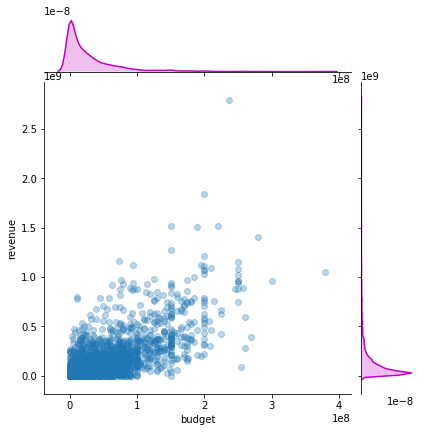

In [7]:
print('Scatterplot and densities of budget and revenue')
g = sns.JointGrid(X.budget,y)
g = g.plot_joint(plt.scatter, cmap="Purples_d",marker='o',alpha=0.3)
g = g.plot_marginals(sns.kdeplot, color="m", shade=True)


In [8]:
#Pearson's correlation heatmap
def heatmap(data):
    print("Pearson's correlation heatmap")
    heat_data = data.copy()
    heat_data['y']=y
    corr = heat_data.corr()
    f, ax = plt.subplots(figsize=(11,9))
    sns.heatmap(corr, linewidths=.3)
    return

Pearson's correlation heatmap


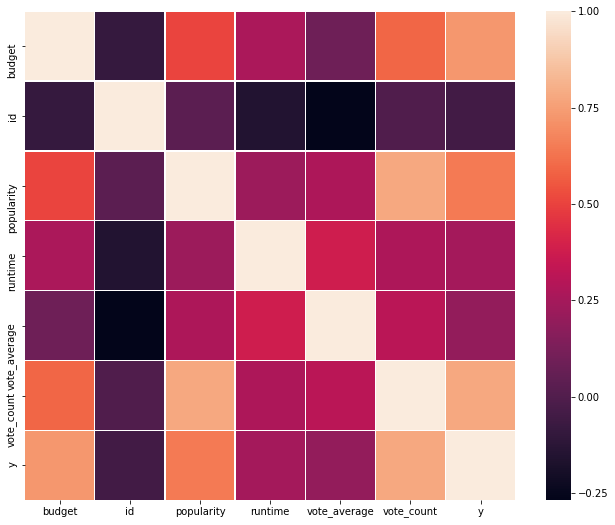

In [9]:
heatmap(X)

# 4. Feature engineering: Target

In this section, the target will be transformed into logarithm and binned into a fixed number of categories.

In [10]:
y.describe()

count    4.793000e+03
mean     8.243209e+07
std      1.629836e+08
min      0.000000e+00
25%      0.000000e+00
50%      1.927131e+07
75%      9.324639e+07
max      2.787965e+09
Name: revenue, dtype: float64

<function matplotlib.pyplot.show>

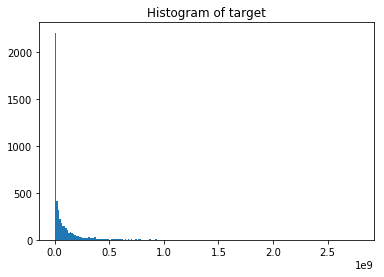

In [11]:
plt.hist(y,bins=200)
plt.title('Histogram of target')
plt.show

[ -2.78796509e+08   2.78796509e+08   5.57593017e+08   8.36389526e+08
   1.11518603e+09   1.39398254e+09   1.67277905e+09   1.95157556e+09
   2.23037207e+09   2.50916858e+09   2.78796509e+11]


<function matplotlib.pyplot.show>

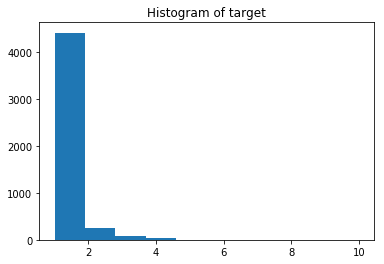

In [12]:
#BINNING:

#Define bins
ybins = pd.cut(y,rev_cat,labels=np.linspace(1,rev_cat,num=rev_cat),retbins=True)[1]
#Expand the margins on the first and last bins to avoid NaNs in case any prediction surpases the bin bounds.
ybins[0]=ybins[0]*100
ybins[-1]=ybins[-1]*100
print(ybins)

#Bin data
ybinned = pd.cut(y,ybins,labels=np.linspace(1,rev_cat,num=rev_cat),retbins=False)
plt.hist(ybinned,bins=rev_cat)
plt.title('Histogram of target')
plt.show

In [13]:
print('describe bins:')
( pd.DataFrame(ybinned).reset_index() ).groupby('revenue').count()


describe bins:


,index
revenue,
1.0,4417
2.0,255
3.0,75
4.0,34
5.0,6
6.0,4
7.0,1
8.0,0
9.0,0


Change target to log

In [14]:
y+=0.1
y=np.log(y)

<function matplotlib.pyplot.show>

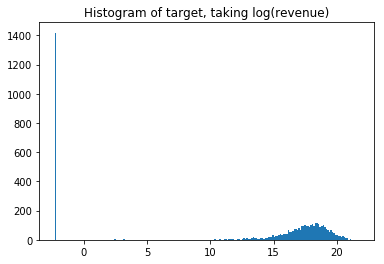

In [15]:
plt.hist(y,bins=200)
plt.title('Histogram of target, taking log(revenue)')
plt.show

[ -2.78796509e+08   2.78796509e+08   5.57593017e+08   8.36389526e+08
   1.11518603e+09   1.39398254e+09   1.67277905e+09   1.95157556e+09
   2.23037207e+09   2.50916858e+09   2.78796509e+11]


<function matplotlib.pyplot.show>

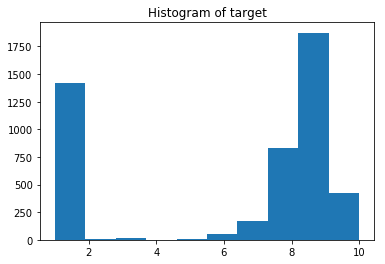

In [16]:
## ybins = pd.cut(y,rev_cat,labels=np.linspace(1,rev_cat,num=rev_cat),retbins=True)[1]
print(ybins)
ybinned = pd.cut(y,rev_cat,labels=np.linspace(1,rev_cat,num=rev_cat),retbins=False)
plt.hist(ybinned,bins=rev_cat)
plt.title('Histogram of target')
plt.show

In [17]:
print('describe bins:')
( pd.DataFrame(ybinned).reset_index() ).groupby('revenue').count()


describe bins:


,index
revenue,
1.0,1418
2.0,8
3.0,12
4.0,2
5.0,10
6.0,52
7.0,167
8.0,827
9.0,1874


# 5. Feature engineering: Features

In [18]:
X.columns

Index(['budget', 'genres', 'homepage', 'id', 'keywords', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'runtime', 'spoken_languages',
       'tagline', 'title', 'vote_average', 'vote_count'],
      dtype='object')

feature cleaning

In [19]:
def unique_values(X,variable,drop):
    ''''
    Check if some selected columns make sense as a feature 
(e.g. if most movies belong to a different collection this qualitative variable is not very descriptive)
    '''
    print('Checking',variable,'....')
    try:
        valid = len(X) - X[variable].isna().sum()
    except:
        valid = len(X) - X[variable].isnull().sum()
    unique = X[variable].nunique()
    try:
        null = X[variable].isna().sum()
    except:
        null = X[variable].isnull().sum()
    valid_distinct = round(unique/(len(X) - null)*100,ndigits=2)
    print('We have',len(X), 'observations, out of which only', valid, 'are not nan')
    print('We have', unique,'different values of',variable)
    print('Thus, ', round(((len(X) - null)/len(X))*100,ndigits=2), '% are valid values and ',valid_distinct,'% of these are distinct values.')
    if valid<(len(X)/2) or valid_distinct>50:
        if drop:
            print('We should get rid of this feature!')
            X.drop(labels=variable, axis=1,inplace=True)
        else:
            print('This feature has several distinct values, as long as it is an ordinal variable we are ok!')
    else:
        print('This feature has frequently repeated (valid) fields...Interesting!')
    #TODO: parse and test t to validate
    print()
    return X

In [20]:
for var in X.drop(labels=['budget','keywords','popularity','runtime','vote_average','vote_count','id','release_date','production_companies'],axis=1).columns:
    X = unique_values(X,var,True)

Checking genres ....
We have 4793 observations, out of which only 4793 are not nan
We have 1175 different values of genres
Thus,  100.0 % are valid values and  24.51 % of these are distinct values.
This feature has frequently repeated (valid) fields...Interesting!

Checking homepage ....
We have 4793 observations, out of which only 1709 are not nan
We have 1688 different values of homepage
Thus,  35.66 % are valid values and  98.77 % of these are distinct values.
We should get rid of this feature!

Checking original_language ....
We have 4793 observations, out of which only 4793 are not nan
We have 37 different values of original_language
Thus,  100.0 % are valid values and  0.77 % of these are distinct values.
This feature has frequently repeated (valid) fields...Interesting!

Checking original_title ....
We have 4793 observations, out of which only 4793 are not nan
We have 4791 different values of original_title
Thus,  100.0 % are valid values and  99.96 % of these are distinct value

In [21]:
# Find the data points with extreme high or low values from a relevant set of features
feature_outliers = []
X['target'] = y
for feature in ['target','budget','vote_average', 'vote_count']:
    
    # TODO: Calculate Q1 (25th percentile of the data) for the given feature
    Q1 = np.percentile(X[feature],25)
    
    # TODO: Calculate Q3 (75th percentile of the data) for the given feature
    Q3 = np.percentile(X[feature],75)
    
    # TODO: Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
    step = 1.5*(Q3-Q1)
    
    # Save the outliers
    feature_outliers_step = (X[~((X[feature] >= Q1 - step) & (X[feature] <= Q3 + step))]).index
    feature_outliers.extend(feature_outliers_step)

X.drop(labels='target',inplace=True,axis=1)    

# Select the indices for data points I wish to remove
outliers  = pd.DataFrame(feature_outliers)
outliers['counts']=np.ones(len(outliers))
outliers = outliers.groupby(0).count()
outliers = X.loc[(outliers[outliers .counts>3]).index]
display(outliers)

print('since no movie is an outlier in these few and relevant features, there is no need to remove the outliers')
#X = X.drop(X.index[outliers]).reset_index(drop = True)

,budget,genres,id,keywords,original_language,popularity,production_companies,production_countries,release_date,runtime,spoken_languages,vote_average,vote_count
0,,,,,,,,,,,,,


since no movie is an outlier in these few and relevant features, there is no need to remove the outliers


In [22]:
def extract_feature_from_dict(data, feat_name):
    '''extract a dataset with one column for all the fields (and one row per field value) from a dataframe'''
    data[feat_name] = data[feat_name].apply(lambda x: list(map(lambda d: list(d.values())[0],
                                                               ast.literal_eval(x)) if isinstance(x, str) else []))
    a=pd.DataFrame(data[feat_name])[feat_name].astype(str).str.split(',',expand=True)
    a[0] = a[0].str.replace('[','')
    for x in range(len(a.columns)):
        a[x] = a[x].str.replace(']','')
    df = pd.DataFrame(a.stack()).reset_index().set_index('level_0').drop('level_1',axis=1)
    df[0]=df[0].str.replace(" ","")
    return df

def filter_reshape_features(data, feat_name, threshold):
    '''takes one series and figures out if there are enough observations of the field. 
    Outputs a dataframe with the relevant values transformed into dummy variables'''
    counts=data.copy()
    #only consider the training data to count
    counts = counts[counts.index.isin(training_ids)]
    #calculate whether there are enough counts to make any assumption
    counts['count']=np.ones(len(counts))
    counts=counts.groupby(0).count().sort_values(by='count')
    enough_counts=counts[counts['count']>threshold].index.tolist()
    #filter out field values that have too low frequency to make any assumptions
    data_filtered=data[data[0].isin(enough_counts)]
    data_filtered=pd.get_dummies(data_filtered).groupby('level_0').sum()
    data_filtered.head()
    return data_filtered


Genres

In [23]:
#Take a column that is a dictinary and return several columns that are dummies.
#Only use the dummies that had a minimum frequency value.

genres = extract_feature_from_dict(X,'genres')
genres_filtered = filter_reshape_features(genres, 'genres', 70)

#tidy up col names:
genres_filtered.columns=genres_filtered.columns.str.replace("0_","genre_")
print('we keep',len(genres_filtered.columns),'genres')

#clean and add genres filtered to the data
X[genres_filtered.columns] = genres_filtered.astype('int64')
X[genres_filtered.columns]=X[genres_filtered.columns].fillna(value=0)
X.drop('genres',inplace=True,axis=1)

we keep 17 genres


Language

In [24]:
X['original_en'] = X['original_language'].apply(lambda x: x == 'en')
X.drop('original_language',axis=1,inplace=True) #this variable is very related to production country plus we already know if the original language is english
X['english_spoken'] = X['spoken_languages'].apply(lambda x: 'en' in x)
X['amount_languages'] = X['spoken_languages'].apply(len)

In [25]:
#Take a column that is a dictinary and return several columns that are dummies.
#Only use the dummies that had a minimum frequency value.

lang = extract_feature_from_dict(X,'spoken_languages')
lang_filtered = filter_reshape_features(lang, 'spoken_languages', 20)

#tidy up col names:
lang_filtered.columns=lang_filtered.columns.str.replace("'","").str.replace("0_","lang_")
print('we keep',len(lang_filtered.columns),'languages')

#clean and add genres filtered to the data
X[lang_filtered.columns] = lang_filtered.astype('int64')
X[lang_filtered.columns]=X[lang_filtered.columns].fillna(value=0)
X.drop('spoken_languages',inplace=True,axis=1)

we keep 20 languages


Production countries

In [26]:
#Take a column that is a dictinary and return several columns that are dummies.
#Only use the dummies that had a minimum frequency value.

prod_countries = extract_feature_from_dict(X,'production_countries')
prod_countries_filtered = filter_reshape_features(prod_countries, 'production_countries', 20)

#tidy up col names:
prod_countries_filtered.columns=prod_countries_filtered.columns.str.replace("'","").str.replace("0_","prod_countries_")
print('we keep',len(prod_countries_filtered.columns),'production_countries')

#clean and add genres filtered to the data
X[prod_countries_filtered.columns] = prod_countries_filtered.astype('int64')
X[prod_countries_filtered.columns]=X[prod_countries_filtered.columns].fillna(value=0)
X.drop('production_countries',inplace=True,axis=1)

we keep 16 production_countries


Production_companies

In [27]:
#Take a column that is a dictinary and return several columns that are dummies.
#Only use the dummies that had a minimum frequency value.

prod_companies = extract_feature_from_dict(X,'production_companies')
prod_companies_filtered = filter_reshape_features(prod_companies, 'production_companies', 80)

#tidy up col names:
prod_companies_filtered.columns=prod_companies_filtered.columns.str.replace("'","").str.replace("0_","prod_companies_")
print('we keep',len(prod_companies_filtered.columns),'production_companies')

#clean and add genres filtered to the data
X[prod_companies_filtered.columns] = prod_companies_filtered.astype('int64')
X[prod_companies_filtered.columns]=X[prod_companies_filtered.columns].fillna(value=0)
X.drop('production_companies',inplace=True,axis=1)

we keep 11 production_companies


In [28]:
#high volume production companies: we can assume they produce (in general terms) the best movies

top4_prod_companies = filter_reshape_features(prod_companies, 'production_companies', 200) 
X['top4_prod_companies'] = np.sum(top4_prod_companies,axis=1) #we keep 4 companies out of 4315

mega_big_prod_companies = filter_reshape_features(prod_companies, 'production_companies', 100)
X['mega_big_prod_companies'] = np.sum(mega_big_prod_companies,axis=1) #we keep 7 companies out of 4315

big_prod_companies = filter_reshape_features(prod_companies, 'production_companies', 20)
X['big_prod_companies'] = np.sum(big_prod_companies,axis=1)#we keep 57 companies out of 4315

medium_prod_companies = filter_reshape_features(prod_companies, 'production_companies', 10)
X['medium_prod_companies'] = np.sum(medium_prod_companies,axis=1)#we keep 116 companies out of 4315

not_small_prod_companies = filter_reshape_features(prod_companies, 'production_companies', 4)
X['not_small_prod_companies'] = np.sum(not_small_prod_companies,axis=1)#we keep 376 companies out of 4315

#convert to dummies: Nan means it doesn't have a big volume company, and more than 1 companies are changed to 1
for feat in ['top4_prod_companies','mega_big_prod_companies','big_prod_companies','medium_prod_companies','not_small_prod_companies']:
    X[feat].fillna(value=0.0,inplace=True)
    X[feat] = (X[feat]>0.0).astype('int64')

keywords

In [29]:
#Take a column that is a dictinary and return several columns that are dummies.
#Only use the dummies that had a minimum frequency value.

keywords = extract_feature_from_dict(X,'keywords')
keywords_filtered = filter_reshape_features(keywords, 'keywords', 70)

#tidy up col names:
keywords_filtered.columns=keywords_filtered.columns.str.replace("'","").str.replace("0_","keywords_")
print('we keep',len(keywords_filtered.columns),'keywords')

#clean and add genres filtered to the data
X[keywords_filtered.columns] = keywords_filtered.astype('int64')
X[keywords_filtered.columns]=X[keywords_filtered.columns].fillna(value=0)
X.drop('keywords',inplace=True,axis=1)

we keep 20 keywords


Release date 

In [30]:
# Parse release year from release date 
release_year=pd.DataFrame(X.release_date.str.split('-',expand=True)[0])
release_year.loc[4553] = '2015' # Add the year for the movie America Is Still the Place.
release_year=release_year.astype('int64')

X.drop('release_date', axis=1, inplace=True)
X['release_year'] = release_year
X['release_year'].describe()


count    4793.000000
mean     2002.453995
std        12.420197
min      1916.000000
25%      1999.000000
50%      2005.000000
75%      2011.000000
max      2017.000000
Name: release_year, dtype: float64

# 6. Exploratory analysis


In [31]:
# generate lists of variables categories to easily slice the dataset for exploratoey analysis and later models
base_variables = ['budget','release_year','runtime', 'original_en','english_spoken','amount_languages']
popularity_variables = [ 'popularity', 'vote_average', 'vote_count'] #These are only available after it premiers
spoken_lang_variables = ['lang_', 'lang_ar', 'lang_cn', 'lang_cs', 'lang_de', 'lang_en',
       'lang_es', 'lang_fr', 'lang_he', 'lang_hi', 'lang_hu', 'lang_it',
       'lang_ja', 'lang_ko', 'lang_la', 'lang_pl', 'lang_pt', 'lang_ru',
       'lang_th', 'lang_zh']
prod_countries_variables = ['prod_countries_', 'prod_countries_AU', 'prod_countries_CA',
       'prod_countries_CN', 'prod_countries_DE', 'prod_countries_ES',
       'prod_countries_FR', 'prod_countries_GB', 'prod_countries_HK',
       'prod_countries_IE', 'prod_countries_IN', 'prod_countries_IT',
       'prod_countries_JP', 'prod_countries_MX', 'prod_countries_NZ',
       'prod_countries_US']
prod_companies_variables = ['top4_prod_companies','mega_big_prod_companies','big_prod_companies',
        'medium_prod_companies','not_small_prod_companies','prod_companies_', 'prod_companies_ColumbiaPictures',
       'prod_companies_Metro-Goldwyn-Mayer(MGM)',
       'prod_companies_NewLineCinema', 'prod_companies_ParamountPictures',
       'prod_companies_RelativityMedia', 'prod_companies_TouchstonePictures',
       'prod_companies_TwentiethCenturyFoxFilmCorporation',
       'prod_companies_UniversalPictures', 'prod_companies_WaltDisneyPictures',
       'prod_companies_WarnerBros.']
keyword_variables = ['keywords_', 'keywords_10183', 'keywords_13130', 'keywords_14819',
       'keywords_179430', 'keywords_179431', 'keywords_187056',
       'keywords_209714', 'keywords_242', 'keywords_4344', 'keywords_4565',
       'keywords_5565', 'keywords_572', 'keywords_6054', 'keywords_6075',
       'keywords_818', 'keywords_9663', 'keywords_9673', 'keywords_9748',
       'keywords_9826']
genre_variables = ['genre_10402', 'genre_10749', 'genre_10751', 'genre_10752', 'genre_12',
       'genre_14', 'genre_16', 'genre_18', 'genre_27', 'genre_28', 'genre_35',
       'genre_36', 'genre_53', 'genre_80', 'genre_878', 'genre_9648',
       'genre_99']


Pearson's correlation heatmap


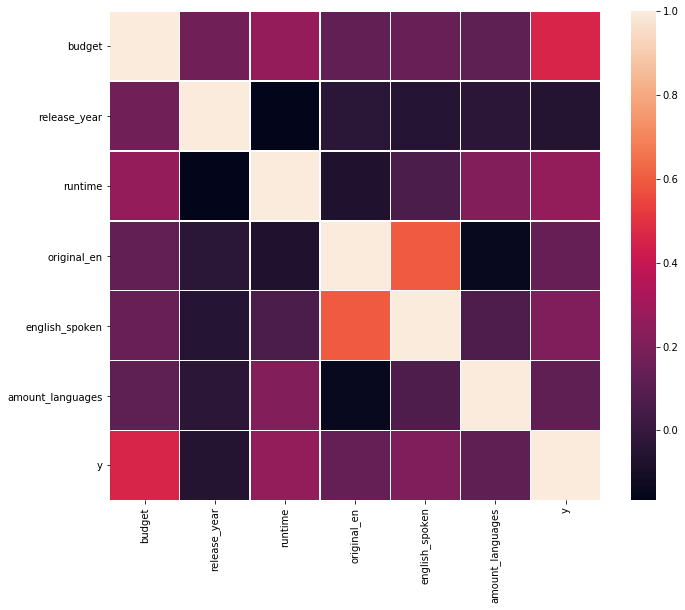

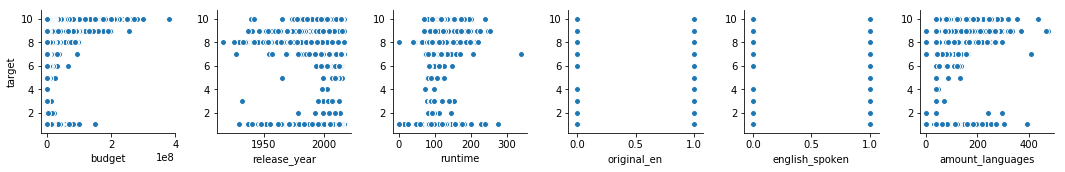

In [32]:
heatmap(X[base_variables])
X['target']=ybinned
pp = sns.pairplot(data=X,y_vars=['target'],x_vars=base_variables)

Pearson's correlation heatmap


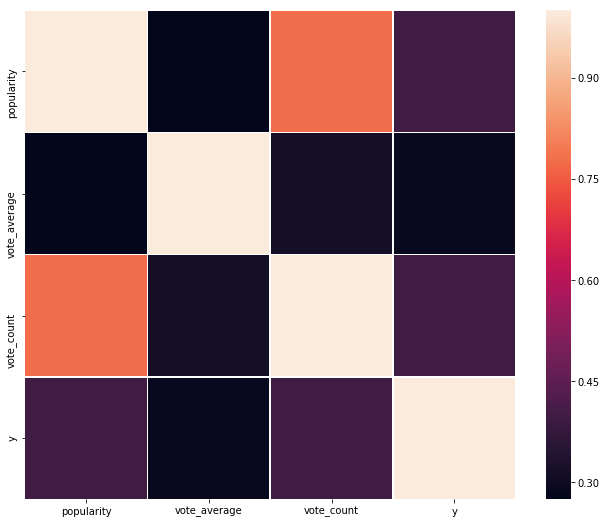

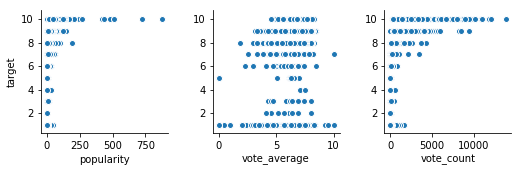

In [33]:
heatmap(X[popularity_variables])
X['target']=ybinned
pp = sns.pairplot(data=X,y_vars=['target'],x_vars=popularity_variables)

Pearson's correlation heatmap


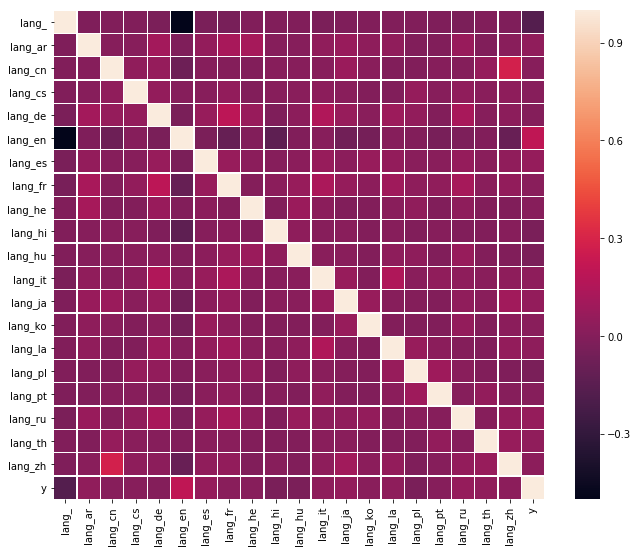

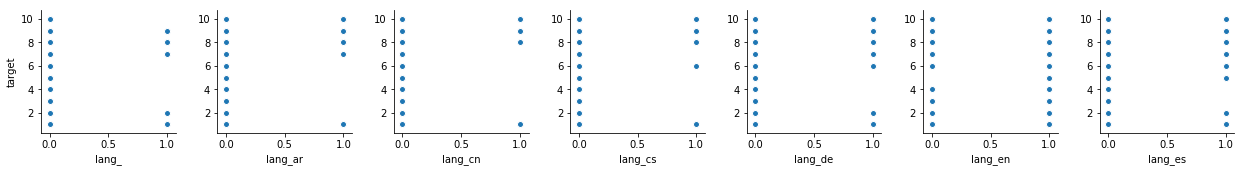

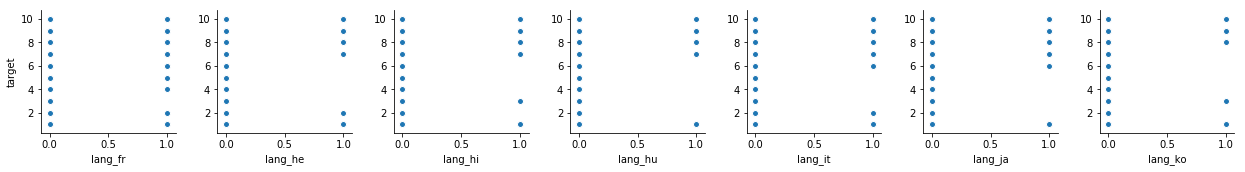

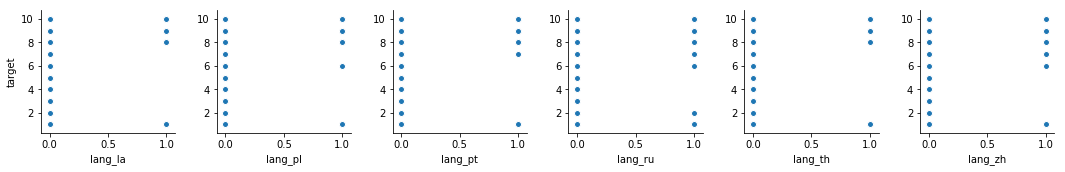

In [34]:
heatmap(X[spoken_lang_variables])
X['target']=ybinned
pp = sns.pairplot(data=X,y_vars=['target'],x_vars=spoken_lang_variables[0:7])
pp = sns.pairplot(data=X,y_vars=['target'],x_vars=spoken_lang_variables[7:14])
pp = sns.pairplot(data=X,y_vars=['target'],x_vars=spoken_lang_variables[14:])

Pearson's correlation heatmap


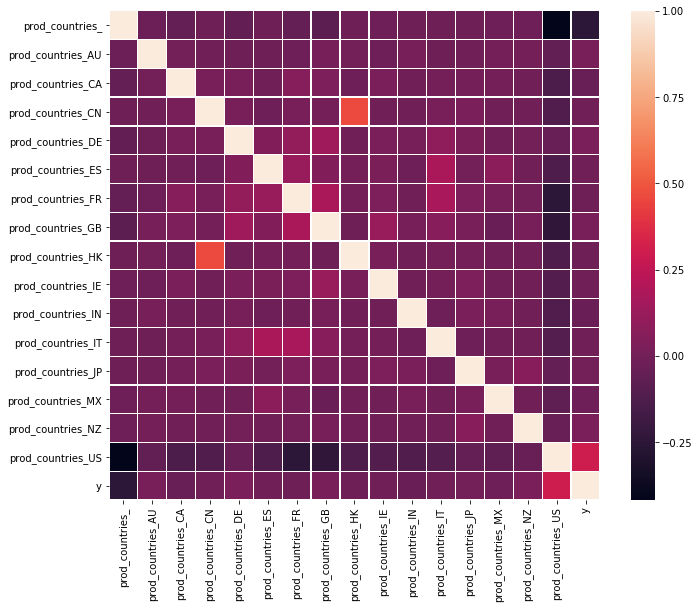

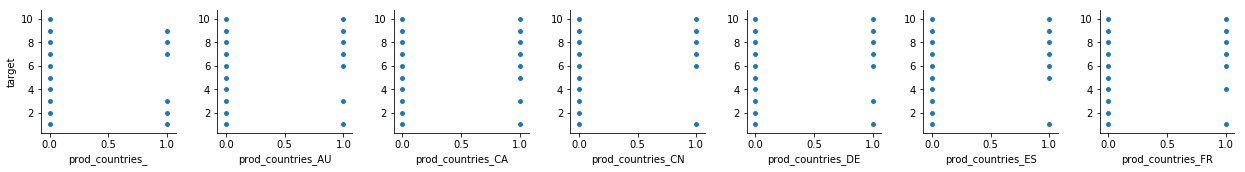

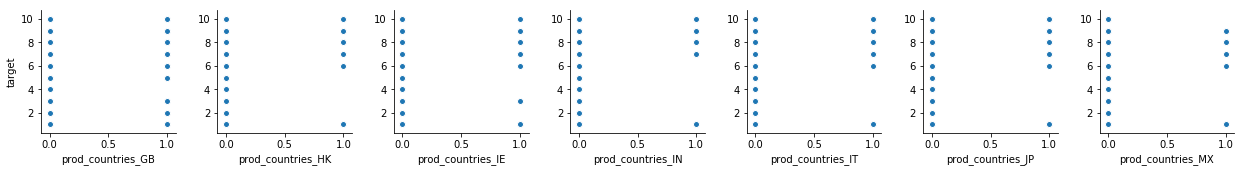

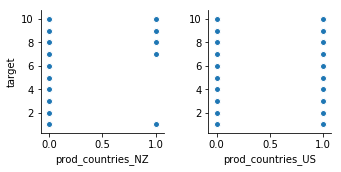

In [35]:
heatmap(X[prod_countries_variables])
X['target']=ybinned
pp = sns.pairplot(data=X,y_vars=['target'],x_vars=prod_countries_variables[0:7])
pp = sns.pairplot(data=X,y_vars=['target'],x_vars=prod_countries_variables[7:14])
pp = sns.pairplot(data=X,y_vars=['target'],x_vars=prod_countries_variables[14:])

Pearson's correlation heatmap


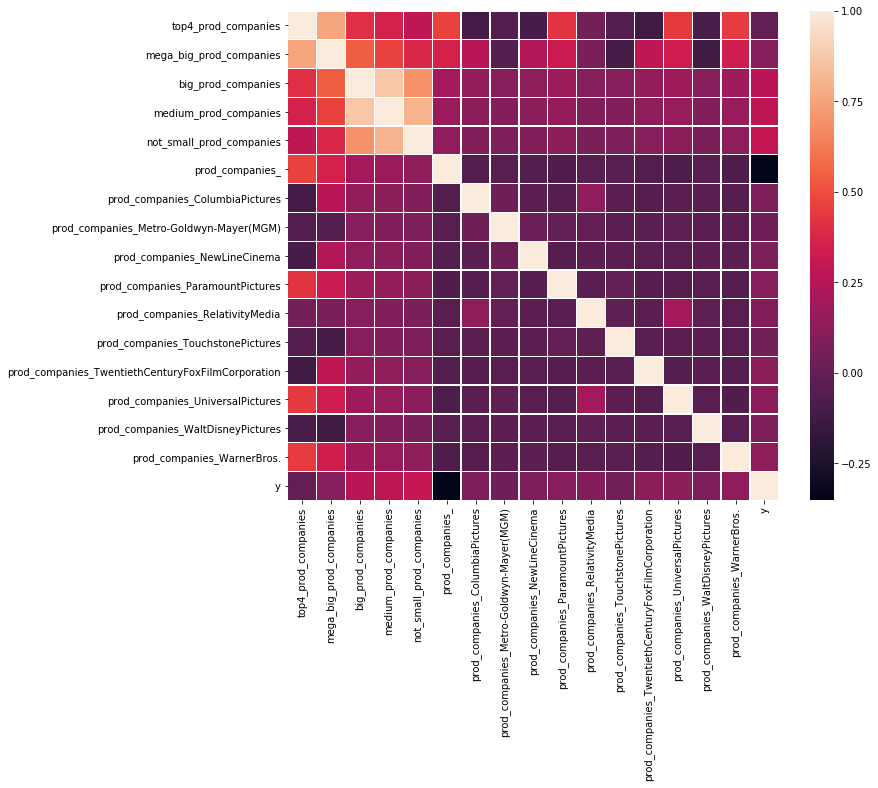

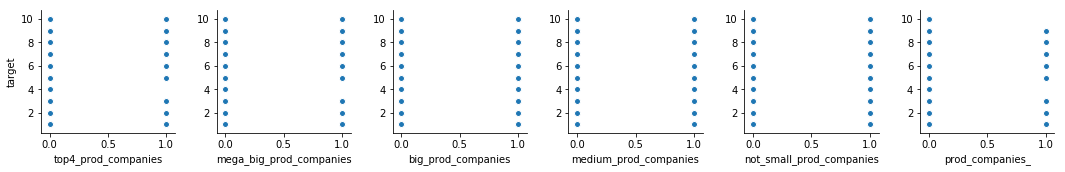

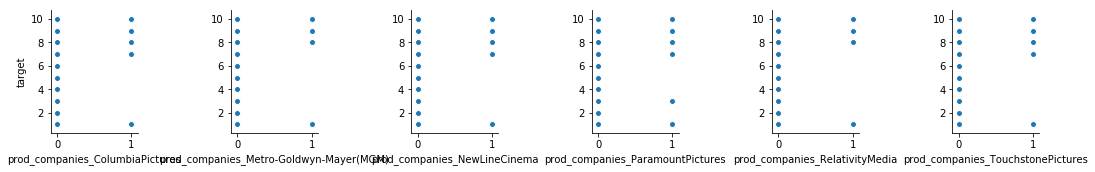

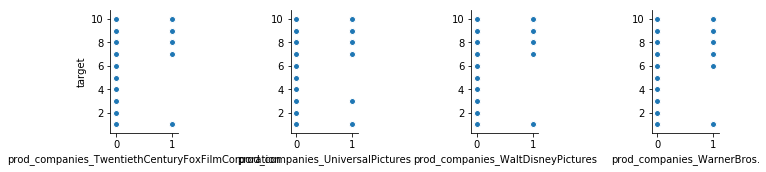

In [36]:
heatmap(X[prod_companies_variables])
X['target']=ybinned
pp = sns.pairplot(data=X,y_vars=['target'],x_vars=prod_companies_variables[0:6])
pp = sns.pairplot(data=X,y_vars=['target'],x_vars=prod_companies_variables[6:12])
pp = sns.pairplot(data=X,y_vars=['target'],x_vars=prod_companies_variables[12:])

Pearson's correlation heatmap


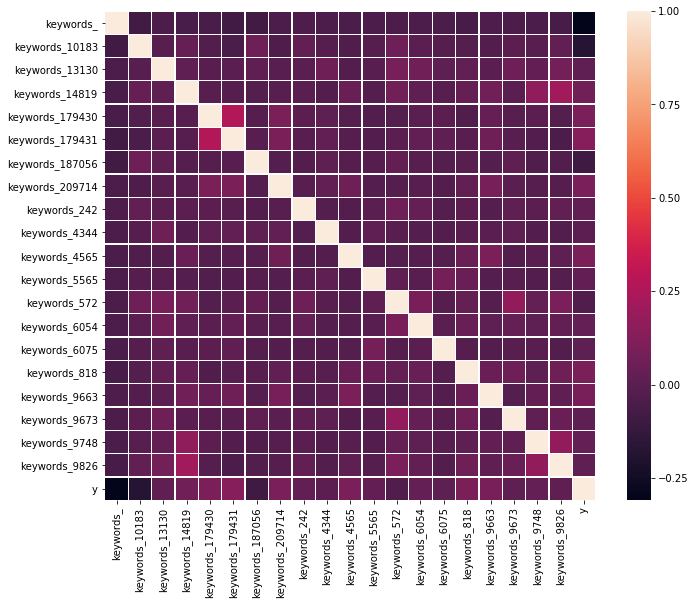

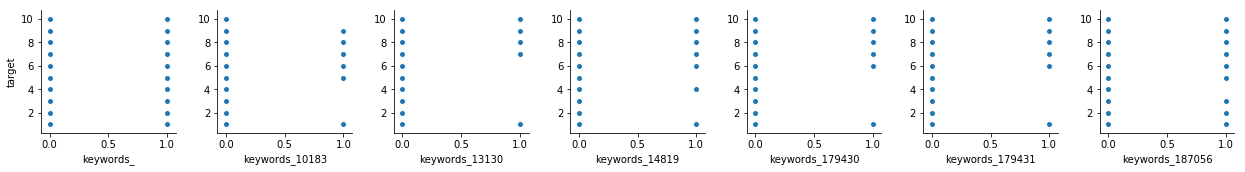

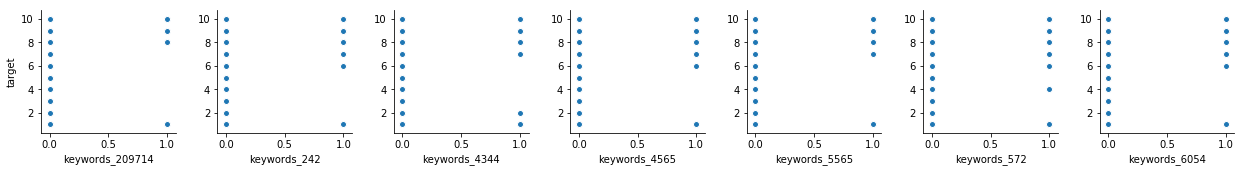

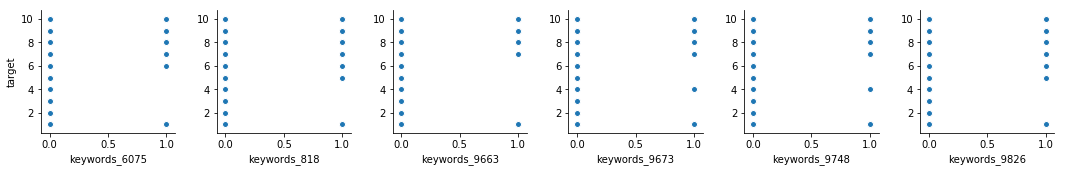

In [37]:
heatmap(X[keyword_variables])

X['target']=ybinned
pp = sns.pairplot(data=X,y_vars=['target'],x_vars=keyword_variables[0:7])
pp = sns.pairplot(data=X,y_vars=['target'],x_vars=keyword_variables[7:14])
pp = sns.pairplot(data=X,y_vars=['target'],x_vars=keyword_variables[14:])

Pearson's correlation heatmap


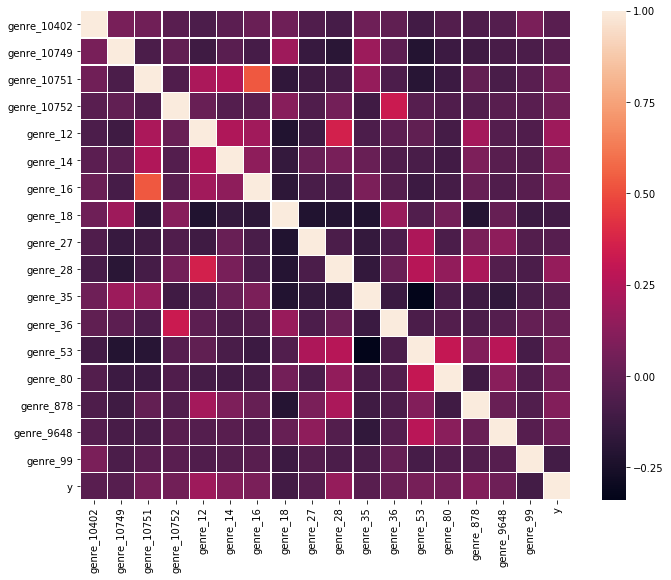

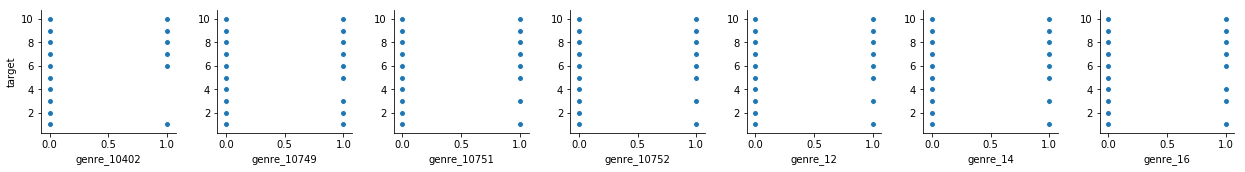

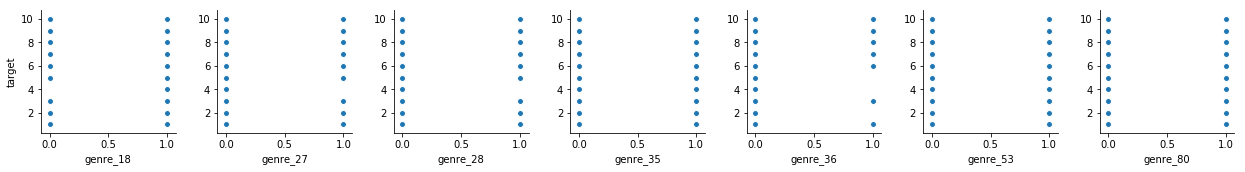

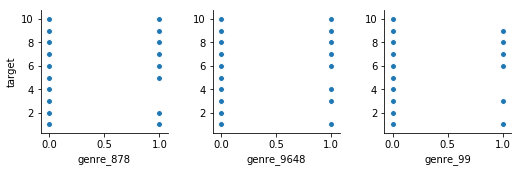

In [38]:
heatmap(X[genre_variables])
X['target']=ybinned
pp = sns.pairplot(data=X,y_vars=['target'],x_vars=genre_variables[0:7])
pp = sns.pairplot(data=X,y_vars=['target'],x_vars=genre_variables[7:14])
pp = sns.pairplot(data=X,y_vars=['target'],x_vars=genre_variables[14:])

In [39]:
X.drop(labels='target',axis=1,inplace=True)
X.columns

Index(['budget', 'id', 'popularity', 'runtime', 'vote_average', 'vote_count',
       'genre_10402', 'genre_10749', 'genre_10751', 'genre_10752', 'genre_12',
       'genre_14', 'genre_16', 'genre_18', 'genre_27', 'genre_28', 'genre_35',
       'genre_36', 'genre_53', 'genre_80', 'genre_878', 'genre_9648',
       'genre_99', 'original_en', 'english_spoken', 'amount_languages',
       'lang_', 'lang_ar', 'lang_cn', 'lang_cs', 'lang_de', 'lang_en',
       'lang_es', 'lang_fr', 'lang_he', 'lang_hi', 'lang_hu', 'lang_it',
       'lang_ja', 'lang_ko', 'lang_la', 'lang_pl', 'lang_pt', 'lang_ru',
       'lang_th', 'lang_zh', 'prod_countries_', 'prod_countries_AU',
       'prod_countries_CA', 'prod_countries_CN', 'prod_countries_DE',
       'prod_countries_ES', 'prod_countries_FR', 'prod_countries_GB',
       'prod_countries_HK', 'prod_countries_IE', 'prod_countries_IN',
       'prod_countries_IT', 'prod_countries_JP', 'prod_countries_MX',
       'prod_countries_NZ', 'prod_countries_US', 'prod_c

# 7. Benchmark model

In [40]:
#Separate training and testing datasets
X_train = X[X.index.isin(training_ids)]
ybinned_train = ybinned[ybinned.index.isin(training_ids)]

X_test = X[X.index.isin(testing_ids)]
ybinned_test = ybinned[ybinned.index.isin(testing_ids)]

y_train = y[y.index.isin(training_ids)]

In [41]:
#linear regression with budget
model = LinearRegression(fit_intercept=False)
model.fit(X_train[['budget']],y_train)

y_pred = pd.DataFrame(model.predict(X_test[['budget']]))
y_pred = pd.cut(y_pred[0],ybins,labels=np.linspace(1,rev_cat,num=rev_cat),retbins=False)

print(f1_score(ybinned_test, y_pred, average='weighted'))
print(f1_score(ybinned_test, y_pred, average=None))
print(f1_score(ybinned_test, y_pred, average='micro'))

0.131129121106
[ 0.45072698  0.          0.          0.          0.          0.          0.
  0.        ]
0.290928050052


/home/veronica/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# 8. Models

In [42]:
def try_model(mod,variables):
    model = mod
    model.fit(X_train[variables],ybinned_train)
    y_pred = model.predict(X_test[variables])
    print(f1_score(ybinned_test, y_pred, average='weighted'))
    print(f1_score(ybinned_test, y_pred, average=None))
    print(f1_score(ybinned_test, y_pred, average='micro'))
    return 'done!'

base variables

In [43]:
print('DecisionTreeClassifier()')
try_model(DecisionTreeClassifier(),base_variables)

print('RandomForestClassifier()')
try_model(RandomForestClassifier(),base_variables)

DecisionTreeClassifier()
0.506546613526
[ 0.65026362  0.4         0.          0.          0.11764706  0.12121212
  0.3003003   0.57256991  0.35294118]
0.506777893639
RandomForestClassifier()
0.582964707989
[ 0.70205479  0.          0.          0.          0.          0.09090909
  0.34461538  0.67082294  0.55944056]
0.59645464025


/home/veronica/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/veronica/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/veronica/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


'done!'

In [44]:
print('DecisionTreeClassifier()')
try_model(DecisionTreeClassifier(),list(pd.DataFrame(spoken_lang_variables).append(pd.DataFrame(base_variables))[0]))

print('RandomForestClassifier()')
try_model(RandomForestClassifier(),list(pd.DataFrame(spoken_lang_variables).append(pd.DataFrame(base_variables))[0]))

/home/veronica/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


DecisionTreeClassifier()
0.505768829056
[ 0.63829787  0.          0.          0.          0.22222222  0.06060606
  0.3090379   0.5679677   0.4047619 ]
0.502606882169
RandomForestClassifier()
0.548605923299
[ 0.67340067  0.          0.          0.          0.26666667  0.04651163
  0.28923077  0.63760897  0.50746269]
0.563086548488


/home/veronica/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/veronica/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


'done!'

prod_countries_variables

In [45]:
print('DecisionTreeClassifier()')
try_model(DecisionTreeClassifier(),list(pd.DataFrame(prod_countries_variables).append(pd.DataFrame(base_variables))[0]))

print('RandomForestClassifier()')
try_model(RandomForestClassifier(),list(pd.DataFrame(prod_countries_variables).append(pd.DataFrame(base_variables))[0]))


DecisionTreeClassifier()


/home/veronica/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


0.514564101277
[ 0.64516129  0.66666667  0.          0.          0.          0.19047619
  0.03278689  0.31843575  0.57723577  0.41916168]
0.509906152242
RandomForestClassifier()
0.576516782359
[ 0.70216306  0.          0.          0.14285714  0.          0.31804281
  0.66750948  0.56944444]
0.593326381648


/home/veronica/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


'done!'

prod_companies_variables

In [46]:
print('DecisionTreeClassifier()')
try_model(DecisionTreeClassifier(),list(pd.DataFrame(prod_companies_variables).append(pd.DataFrame(base_variables))[0]))

print('RandomForestClassifier()')
try_model(RandomForestClassifier(),list(pd.DataFrame(prod_companies_variables).append(pd.DataFrame(base_variables))[0]))


DecisionTreeClassifier()


/home/veronica/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


0.512917062264
[ 0.66552316  0.          0.          0.          0.31578947  0.05714286
  0.26315789  0.56984786  0.47560976]
0.509906152242
RandomForestClassifier()
0.580845478316
[ 0.72852234  0.          0.          0.13333333  0.          0.3573487
  0.65581977  0.5       ]
0.594369134515


'done!'

keyword_variables

In [47]:
print('DecisionTreeClassifier()')
try_model(DecisionTreeClassifier(),list(pd.DataFrame(keyword_variables).append(pd.DataFrame(base_variables))[0]))

print('RandomForestClassifier()')
try_model(RandomForestClassifier(),list(pd.DataFrame(keyword_variables).append(pd.DataFrame(base_variables))[0]))


DecisionTreeClassifier()


/home/veronica/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


0.530575709191
[ 0.63778163  0.4         0.          0.          0.24        0.03333333
  0.32876712  0.59833795  0.5125    ]
0.527632950991
RandomForestClassifier()
0.587571073439
[ 0.71724138  0.          0.          0.          0.04081633  0.31921824
  0.69147659  0.53846154]
0.605839416058


/home/veronica/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


'done!'

genre_variables

In [48]:
print('DecisionTreeClassifier()')
try_model(DecisionTreeClassifier(),list(pd.DataFrame(genre_variables).append(pd.DataFrame(base_variables))[0]))

print('RandomForestClassifier()')
try_model(RandomForestClassifier(),list(pd.DataFrame(genre_variables).append(pd.DataFrame(base_variables))[0]))


DecisionTreeClassifier()
0.516187525807
[ 0.60105448  0.          0.          0.          0.09090909  0.03448276
  0.33787466  0.59697387  0.48484848]
0.513034410845
RandomForestClassifier()
0.568290413417
[ 0.70666667  0.          0.          0.          0.          0.30921053
  0.6593674   0.53333333]
0.590198123045


/home/veronica/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/veronica/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/veronica/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


'done!'

In [49]:
popularity_variables

['popularity', 'vote_average', 'vote_count']

In [50]:
print('DecisionTreeClassifier()')
try_model(DecisionTreeClassifier(),list(pd.DataFrame(popularity_variables).append(pd.DataFrame(base_variables))[0]))

print('RandomForestClassifier()')
try_model(RandomForestClassifier(),list(pd.DataFrame(popularity_variables).append(pd.DataFrame(base_variables))[0]))


DecisionTreeClassifier()


/home/veronica/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


0.595886236881
[ 0.68610635  0.          0.          0.          0.17391304  0.13793103
  0.34730539  0.68965517  0.63291139]
0.598540145985
RandomForestClassifier()
0.658107492648
[ 0.74788494  0.          0.          0.          0.          0.4548105
  0.76372925  0.64827586]
0.672575599583


/home/veronica/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


'done!'

all variables

In [51]:
print('SVM()')
try_model(svm.SVC(),X.columns)

print('DecisionTreeClassifier()')
try_model(DecisionTreeClassifier(),X.columns)

print('RandomForestClassifier()')
try_model(RandomForestClassifier(),X.columns)

print('GradientBoostingClassifier()')
try_model(GradientBoostingClassifier(),X.columns)


SVM()


/home/veronica/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/veronica/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.22613499789
[ 0.00714286  0.          0.          0.          0.          0.
  0.56694091  0.        ]
0.396246089677
DecisionTreeClassifier()
0.597701270856
[ 0.69824561  0.5         0.          0.24        0.05633803  0.38181818
  0.67899604  0.59493671]
0.59645464025
RandomForestClassifier()
0.656163839867
[ 0.74172185  0.          0.          0.          0.          0.45592705
  0.76674938  0.62992126]
0.675703858186
GradientBoostingClassifier()
0.694683470624
[ 0.7862069   0.          0.          0.          0.          0.
  0.51612903  0.79652605  0.6618705 ]
0.712200208551


/home/veronica/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


'done!'

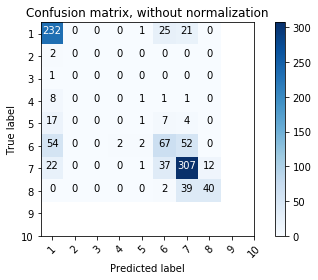

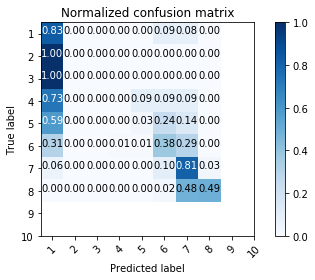

In [52]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function plots the confusion matrix. It was taken (and modified) from an example in
    the sklearn documentation(https://scikit-learn.org/stable/auto_examples/
    model_selection/plot_confusion_matrix.html)
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

model = RandomForestClassifier()
model.fit(X_train,ybinned_train)
y_pred = model.predict(X_test)
# Compute confusion matrix
class_names = [1,2,3,4,5,6,7,8,9,10]
cnf_matrix = confusion_matrix(ybinned_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()


# 9. Refinement

Increase number of estimators to 200

In [53]:
print('SVM()')
try_model(svm.SVC(),X.columns)

print('DecisionTreeClassifier()')
try_model(DecisionTreeClassifier(),X.columns)

print('RandomForestClassifier(n_estimators=200)')
try_model(RandomForestClassifier(n_estimators=200),X.columns)

print('GradientBoostingClassifier(estimators=200)')
try_model(GradientBoostingClassifier(n_estimators=200),X.columns)

SVM()


/home/veronica/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/veronica/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


0.22613499789
[ 0.01  0.    0.    0.    0.    0.    0.57  0.  ]
0.396246089677
DecisionTreeClassifier()
0.610833504088
[ 0.7   0.5   0.    0.    0.15  0.06  0.38  0.71  0.64]
0.611053180396
RandomForestClassifier(n_estimators=200)


/home/veronica/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.683452113691
[ 0.78  0.    0.    0.    0.    0.45  0.8   0.7 ]
0.70802919708
GradientBoostingClassifier(estimators=200)
0.691563652076
[ 0.78  0.    0.    0.    0.    0.    0.52  0.79  0.67]
0.706986444213


/home/veronica/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


'done!'

In [54]:
X['budget'] += 0.1
X['budget'] = np.log(X['budget'])

In [55]:
#Separate training and testing datasets
X_train = X[X.index.isin(training_ids)]
ybinned_train = ybinned[ybinned.index.isin(training_ids)]

X_test = X[X.index.isin(testing_ids)]
ybinned_test = ybinned[ybinned.index.isin(testing_ids)]

y_train = None

In [56]:
print('SVM')
try_model(svm.SVC(),X.columns)

print('DecisionTreeClassifier')
try_model(DecisionTreeClassifier(),X.columns)

print('RandomForestClassifier(n_estimators=200)')
try_model(RandomForestClassifier(n_estimators=200),X.columns)

print('GradientBoostingClassifier(estimators=200)')
try_model(GradientBoostingClassifier(n_estimators=200),X.columns)

SVM()


/home/veronica/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.22613499789
[ 0.01  0.    0.    0.    0.    0.    0.57  0.  ]
0.396246089677
DecisionTreeClassifier()
0.597215901232
[ 0.7   0.4   0.    0.15  0.06  0.38  0.67  0.62]
0.597497393118
RandomForestClassifier(n_estimators=200)


/home/veronica/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.683359361143
[ 0.78  0.    0.    0.    0.    0.45  0.79  0.69]
0.70802919708
GradientBoostingClassifier(estimators=200)
0.690053888287
[ 0.77  0.    0.    0.    0.    0.    0.52  0.79  0.67]
0.704900938478


/home/veronica/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


'done!'

In [57]:
X['budget'] = np.exp(X['budget'])
X['budget'] -= 0.1

Change the bins looking at the histogram and iterating looking at the results

<function matplotlib.pyplot.show>

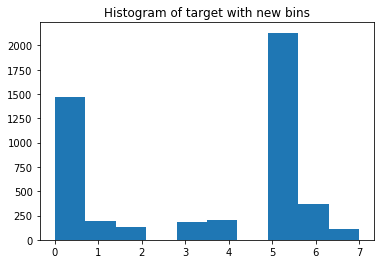

In [58]:
bins_threshold = [-3,11,14.5,15.25,15.9,16.4,19.26,20.2,30]
ybinned = pd.cut(y,bins_threshold,labels=range(len(bins_threshold)-1),retbins=False)
plt.hist(ybinned)
plt.title('Histogram of target with new bins')
plt.show

In [59]:
#Separate training and testing datasets
X_train = X[X.index.isin(training_ids)]
ybinned_train = ybinned[ybinned.index.isin(training_ids)]

X_test = X[X.index.isin(testing_ids)]
ybinned_test = ybinned[ybinned.index.isin(testing_ids)]


In [60]:
print('SVM()')
try_model(svm.SVC(),X.columns)

print('DecisionTreeClassifier()')
try_model(DecisionTreeClassifier(),X.columns)

print('RandomForestClassifier(n_estimators=200)')
try_model(RandomForestClassifier(n_estimators=200),X.columns)

print('GradientBoostingClassifier(estimators=200)')
try_model(GradientBoostingClassifier(n_estimators=200),X.columns)


SVM()


/home/veronica/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.289781020861
[ 0.01  0.    0.    0.    0.    0.63  0.    0.  ]
0.458811261731
DecisionTreeClassifier()
0.59934013105
[ 0.72  0.14  0.08  0.03  0.15  0.72  0.4   0.55]
0.601668404588
RandomForestClassifier(n_estimators=200)


/home/veronica/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.66380192795
[ 0.78  0.    0.    0.05  0.05  0.82  0.52  0.65]
0.722627737226
GradientBoostingClassifier(estimators=200)
0.675831041887
[ 0.78  0.04  0.14  0.08  0.13  0.81  0.57  0.62]
0.713242961418


'done!'

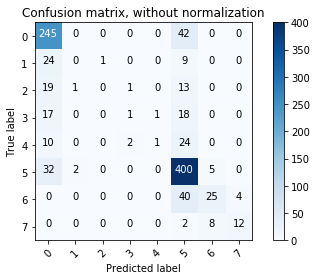

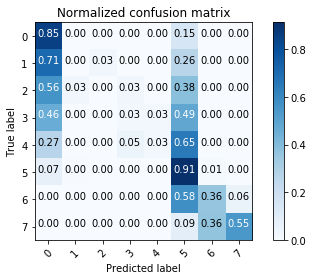

In [61]:
max_leaf_nodes = [1000,10000,100000]
min_samples_split = [2,3]
model = RandomForestClassifier(n_estimators=200)
model.fit(X_train,ybinned_train)
y_pred = model.predict(X_test)

# Compute confusion matrix
class_names = [0,1,2,3,4,5,6,7]
cnf_matrix = confusion_matrix(ybinned_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()


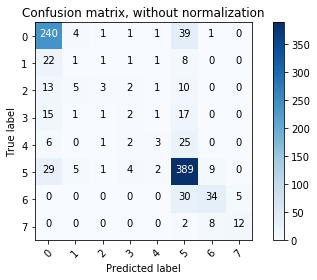

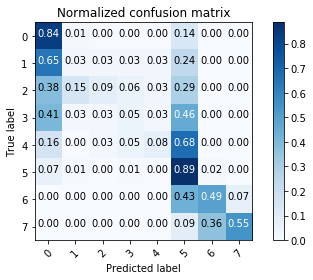

In [62]:
model = GradientBoostingClassifier(n_estimators=200)
model.fit(X_train,ybinned_train)
y_pred = model.predict(X_test)

# Compute confusion matrix
cnf_matrix = confusion_matrix(ybinned_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()



Grid search

/home/veronica/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/veronica/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/veronica/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/veronica/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted',

parameters {'criterion': 'entropy', 'max_leaf_nodes': 1000, 'min_samples_split': 2}
best score gridsearch 0.472660760379
estimator used RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=1000,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)


/home/veronica/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.659699471933
[ 0.78  0.    0.    0.    0.    0.82  0.51  0.63]
0.722627737226


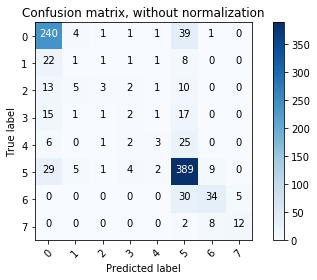

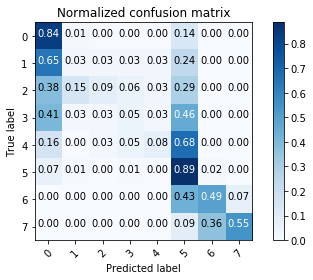

In [63]:
max_leaf_nodes = [1000,10000,100000]
min_samples_split = [2,3]
criterion=['gini','entropy']
param_grid = {'max_leaf_nodes': max_leaf_nodes, 'criterion' : criterion, 'min_samples_split':min_samples_split}
#param_grid = {}
f1_scorer = make_scorer(f1_score,average='weighted')

grid_search = model_selection.GridSearchCV(RandomForestClassifier(n_estimators=200,random_state=42), param_grid,scoring=f1_scorer, cv=2)
grid_search.fit(X_train, ybinned_train)
print('parameters',grid_search.best_params_)
print('best score gridsearch', grid_search.best_score_)

estimator = grid_search.best_estimator_
print('estimator used',estimator)
try_model(estimator,X.columns)

# Compute confusion matrix
cnf_matrix = confusion_matrix(ybinned_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()



/home/veronica/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/veronica/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/veronica/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


parameters {'learning_rate': 0.01}
best score gridsearch 0.399261971034
estimator used GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False)
0.662181806918
[ 0.78  0.05  0.    0.09  0.14  0.81  0.45  0.54]
0.715328467153


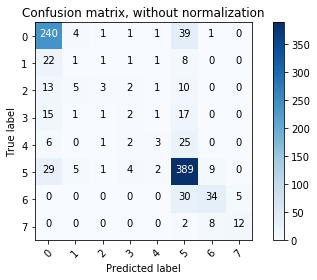

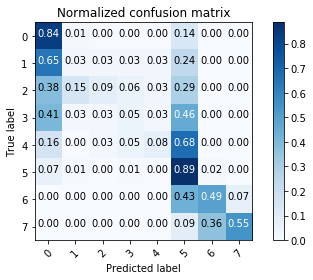

In [64]:
lr = [0.1,0.025,0.01,0.005]
param_grid = {'learning_rate': lr}
f1_scorer = make_scorer(f1_score,average='weighted')

grid_search = model_selection.GridSearchCV(GradientBoostingClassifier(n_estimators=200,random_state=42), param_grid,scoring=f1_scorer, cv=2)
grid_search.fit(X_train, ybinned_train)
print('parameters',grid_search.best_params_)
print('best score gridsearch', grid_search.best_score_)

estimator = grid_search.best_estimator_
print('estimator used',estimator)
try_model(estimator,X.columns)

# Compute confusion matrix
cnf_matrix = confusion_matrix(ybinned_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()


# 11. How would the model do with only 2000 observations in the training set?

0.639771877204
[ 0.74  0.    0.04  0.    0.24  0.8   0.42  0.51]
0.685088633994


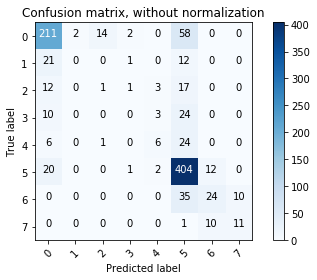

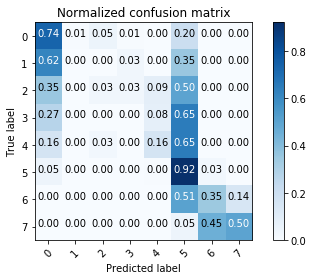

In [67]:
model = GradientBoostingClassifier(n_estimators=200, learning_rate=0.01)
model.fit(X_train.head(2000),ybinned_train.head(2000))
y_pred = model.predict(X_test)
print(f1_score(ybinned_test, y_pred, average='weighted'))
print(f1_score(ybinned_test, y_pred, average=None))
print(f1_score(ybinned_test, y_pred, average='micro'))

# Compute confusion matrix
cnf_matrix = confusion_matrix(ybinned_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()



# 12. how would the model do without popularity variables?

/home/veronica/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.63664698025
[ 0.76  0.05  0.    0.05  0.15  0.78  0.45  0.51]
0.690302398332
0.639771877204
[ 0.74  0.    0.04  0.    0.24  0.8   0.42  0.51]
0.685088633994


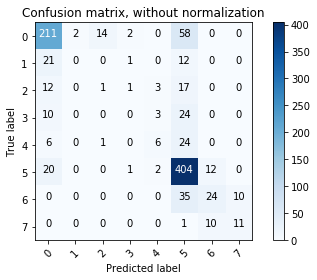

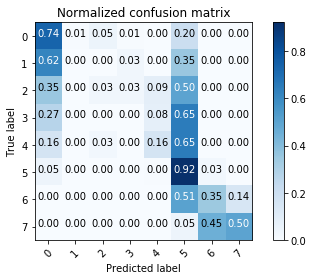

In [68]:
try_model(GradientBoostingClassifier(n_estimators=200, learning_rate=0.01),X.drop(popularity_variables,axis=1).columns)
model = GradientBoostingClassifier(n_estimators=200, learning_rate=0.01)
model.fit(X_train.drop(popularity_variables,axis=1),ybinned_train)
print(f1_score(ybinned_test, y_pred, average='weighted'))
print(f1_score(ybinned_test, y_pred, average=None))
print(f1_score(ybinned_test, y_pred, average='micro'))

# Compute confusion matrix
cnf_matrix = confusion_matrix(ybinned_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()



# 13. Some perspective on the revenue levels

In [71]:
print('These are the thresholds used to define the level categories:')
for x in bins_threshold:
    print(int(np.exp(x)))

these are the thresholds used to define the level categories:
0
59874
1982759
4197501
8040485
13256519
231479066
592582107
10686474581524
